# Dealing with one-shot classes
Notebook created for 28.11 meeting figures and data

In [383]:
import pandas as pd
import pickle
import random
import numpy as np
# Let's look at making the FAQ list better
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from joblib import load, dump
# Playing around with CV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, make_scorer, log_loss
from sklearn.linear_model import LogisticRegression, MultiTaskLassoCV
from sklearn.multiclass import OneVsRestClassifier, 


# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
faq_path = '/Users/margheritarosnati/Documents/DS/2018-2/DSLab/DSL2018-Proj-ETH-IT/data/12-04-faq_dat.csv'
tix_path = '/Users/margheritarosnati/Documents/DS/2018-2/DSLab/DSL2018-Proj-ETH-IT/data/12-04-ticket_dat.csv'

In [3]:
ticket_dat = pd.read_csv(tix_path)
faq_dat = pd.read_csv(faq_path)

In [4]:
print(ticket_dat.shape, faq_dat.shape )
# we'll have to work on these two at some point (soon!)
ticket_dat.fillna('', inplace=True)
faq_dat.fillna('', inplace=True)

(4206, 6) (199, 7)


In [7]:
#print(faq_dat.head())

In [8]:
# Create data lists
faq_ques = list(faq_dat.question)
n_faq_ques = len(faq_ques)

faq_ans = list(faq_dat.answer_title + " " + faq_dat.answer)
n_faq_ans = len(faq_ans)

ticket_ques = list(ticket_dat.question)
n_ticket_ques = len(ticket_ques)

ticket_ans = list(ticket_dat.answer)
n_ticket_ans = len(ticket_ans)

In [9]:
print( len(faq_ans), len(ticket_ans))

199 4206


In [10]:
# initialise model
TFiDF = TfidfVectorizer(strip_accents='unicode', lowercase=True,analyzer='word')
# create matrix: rows = all ans; cols = TI-IDF weighted word vector
all_ans = list(faq_ans) + list(ticket_ans)
TFiDF.fit(all_ans)
faq_mat = TFiDF.transform(faq_ans)
tix_mat = TFiDF.transform(ticket_ans)
# DEBUG:
print(faq_mat.shape,tix_mat.shape, len(faq_ans), len(ticket_ans), len(all_ans))

(199, 15807) (4206, 15807) 199 4206 4405


In [11]:
# Calculate similarities between faq ans and ticket ans
SM = cosine_similarity(faq_mat, tix_mat)
print(SM.shape)

(199, 4206)


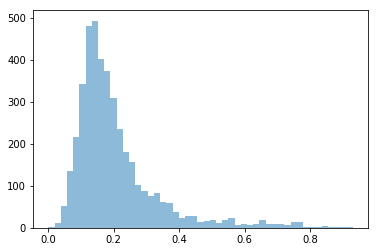

In [12]:
# take highest scoring FAQ per ticket
# plot similarity distribution
strength_FAQ_ticket = np.max(SM, axis=0)
bins =  np.linspace(0, max(strength_FAQ_ticket),50)
plt.hist(strength_FAQ_ticket, bins,alpha=.5, range=(0,1))
plt.show()

In [13]:
# some stats:
thres = np.asarray([0.5, 0.3, 0.2, 0.1])
denom = len(strength_FAQ_ticket)
print([round(np.sum(strength_FAQ_ticket>i)/denom,2) for i in thres])

[0.05, 0.15, 0.36, 0.88]


In [14]:
# VISUALISATION
FAQ_per_ticket = np.argmax(SM, axis=0)
#unique, counts = np.unique(FAQ_per_ticket, return_counts=True)

In [15]:
# creating some samples
subspace =np.nonzero(strength_FAQ_ticket<0.2)
a = random.sample(list(subspace[0]), 1)[0]
b = FAQ_per_ticket[a] 

In [17]:
# Looking at samples created
print("Similarity score: ", strength_FAQ_ticket[a], '\t\t[',a,',',b,'],')
print('\nTicket: ques:\t', ticket_ques[a], '\n\ntick_ans:\t', ticket_ans[a])
print('\n\nFAQ: ques:\t', faq_ques[b], '\n\nFAQ_ans:\t', faq_ans[b])

Similarity score:  0.07902606520396652 		[ 161 , 24 ],

Ticket: ques:	 Dear Mr. Greuter As mentioned on the phone, may I ask you and your colleagues to temporarily increase the daily mail dispatch of [1] online-pruefungen@let.ethz.ch? Unfortunately, the last time window was not enough (see ticket [ID # 18036551].) Again I, Carmen Ghisleni, will be the person who sends the mails. Please let me know if this change can not be made before noon today - then I have to reschedule. Thank you for your feedback. Sincerely, Carmen Ghisleni Team Online Testing Online Testing | Teaching Development and Technology (LET) | ETH Zurich | Haldenbachstrasse 44 | 8092 Zürich / Switzerland E-Mail: [2] online-pruefungen@let.ethz.ch [1] mailto: online-pruefungen@let.ethz.ch [2] mailto: online-pruefungen@let.ethz.ch 

tick_ans:	 Dear Ms Ghisleni The policy has been adjusted. Please restart Outlook before shipping. Your ID Team Joel Greuter


FAQ: ques:	 I want to set an Out of Office Assistant 

FAQ_ans:	 How

In [16]:
# samples in 29.11 presentation
samples = {
    50:[299, 171],
    30:[ 2613 , 12 ],
    20: [ 61 , 172 ],
    'vals': [57,31,13]
}

In [17]:
[a,b] = samples[50]

In [19]:
# allocate <50% sim to -1
med = np.median(strength_FAQ_ticket)
# to give you a feel:
print(np.median(SM), np.median(strength_FAQ_ticket))

0.03819700994459483 0.16903521779028374


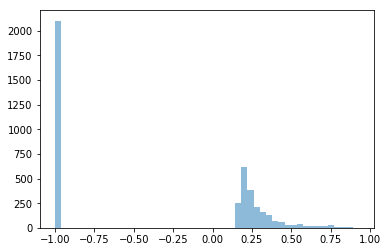

In [20]:
# try I: med over all similarities
# look at distribution
sf2t = np.copy(strength_FAQ_ticket)
sf2t[sf2t<med] = -1
f2t = np.copy(FAQ_per_ticket)
f2t[sf2t<med] = -1
bins =  np.linspace(-1, max(strength_FAQ_ticket),50)
plt.hist(sf2t, bins,alpha=.5)
plt.show()

In [21]:
# let's look at the distribution over FAQs
# I saved the output of the RF here:
RF_out = load('/Users/margheritarosnati/Desktop/temp.joblib')

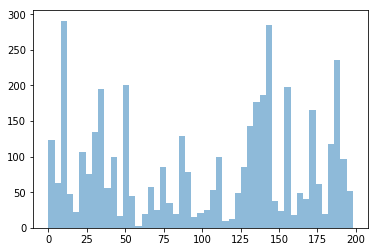

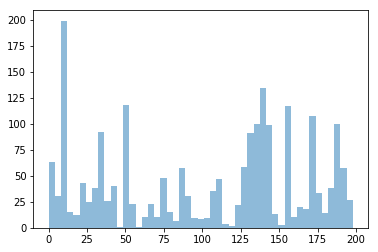

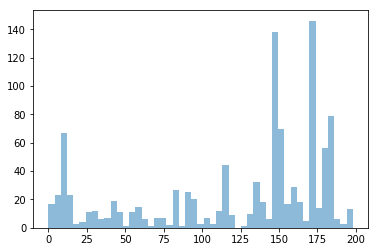

In [22]:
bins =  np.linspace(0, max(FAQ_per_ticket))
plt.hist(FAQ_per_ticket, bins,alpha=.5)
plt.show()
plt.hist(f2t, bins,alpha=.5)
plt.show()
plt.hist(RF_out, bins,alpha=.5)
plt.show()

In [23]:
unique, counts = np.unique(FAQ_per_ticket, return_counts=True)
u2, c2 = np.unique(f2t, return_counts=True)

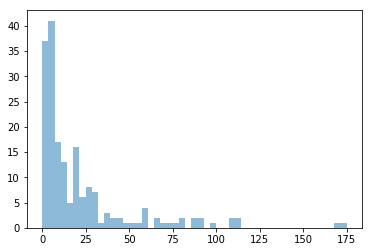

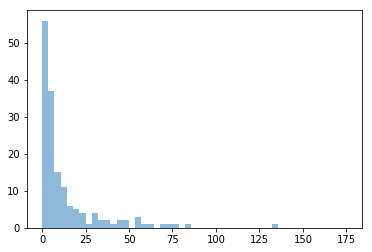

In [24]:
bins =  np.linspace(0, 175,50)
plt.hist(counts, bins,alpha=.5)
plt.show()
plt.hist(c2, bins,alpha=.5)
plt.show()

In [ ]:
# next steps: check what the low ones are getting associated to: is it justified or not?

# New as of 05Dec

In [37]:
# Idea: look at 1 FAQ classes: who is the ticket, what is the certainty there
# use :      unique, counts = np.unique(FAQ_per_ticket, return_counts=True)
# One FAQ classes:
one_faq = unique[counts == 1]
# How many?
print(sum(counts ==1)," unique classes, %:", round(sum(counts==1)/len(faq_ans),2))

15  unique classes, %: 0.08


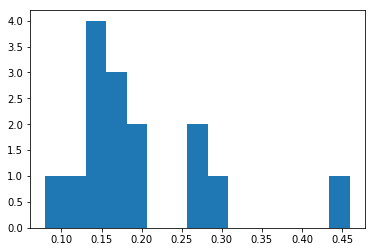

In [49]:
# according to our current sim measure, how good are these?
list_a = []
for j in range(len(one_faq)):
    list_a += [np.nonzero(FAQ_per_ticket == one_faq[j])[0][0]]
# we LOVE histograms
plt.hist(strength_FAQ_ticket[list_a], bins= 15)
plt.show()

In [38]:
# what does it corresponds to?
i = 0
b = one_faq[i]
a = np.nonzero(FAQ_per_ticket == b)[0][0]
# Check it out:
# Looking at samples created
print("Similarity score: ", strength_FAQ_ticket[a], '\t\t[',a,',',b,'],')
print('\nTicket: ques:\t', ticket_ques[a], '\n\ntick_ans:\t', ticket_ans[a])
print('\n\nFAQ: ques:\t', faq_ques[b], '\n\nFAQ_ans:\t', faq_ans[b])

Similarity score:  0.16831407027727743 		[ 3534 , 5 ],

Ticket: ques:	 Good day I&#39;m trying unsuccessfully to establish a VPN connection to the ETH Nethwerk with my computer. I have the Cicso AnyConnect Secure Mobility Client installed. However, I always fail with this dialog box (see figure in the appendix). What is the correct input here? Or what else can I try? Sincerely, Sabrina Strub 

tick_ans:	 Dear Ms Sabrina Strub You must enter the server path there as follows: sslvpn.ethz.ch Your ID Team Mirel Kisic


FAQ: ques:	 Settings for VPN 

FAQ_ans:	 VPN settings of the ETH  The settings for the ETH VPN are as follows:Server: sslvpn.ethz.chDecryption-typ: ipsec-pskUsername: Your ETH-UsernamePassword: Your passwordGroupname: ETHZ-spezialGrouppassword: This information you can find on this page:https://www1.ethz.ch/id/servicedesk/guide/vpn/vpn_secret


In [51]:
# what does it corresponds to?
i = 3
b = one_faq[i]
a = np.nonzero(FAQ_per_ticket == b)[0][0]
# Check it out:
# Looking at samples created
print("Similarity score: ", strength_FAQ_ticket[a], '\t\t[',a,',',b,'],')
print('\nTicket: ques:\t', ticket_ques[a], '\n\ntick_ans:\t', ticket_ans[a])
print('\n\nFAQ: ques:\t', faq_ques[b], '\n\nFAQ_ans:\t', faq_ans[b])

Similarity score:  0.30133104928428234 		[ 3606 , 62 ],

Ticket: ques:	 Good day For several days, the polybox app does not work anymore: it loads, but it does not respond to touch screen touches. Reinstallation and restart bring nothing. Device: Samsung Galaxy 4. Best regards Anian AltherrThank you, that solves the problem. 

tick_ans:	 Dear Mr. Altherr Thank you for your request. With the Polybox App, in conjunction with apps for adjusting the screen brightness such as &quot;LUX&quot; or &quot;Twillight&quot;, it may freeze the screen. If you have such an app installed, you would need to add polybox to the exclude list of this app. (See also [1] https://github.com/owncloud/android/issues/1799). Sincerely, Gianluca Caratsch Your ID Team Gianluca Caratsch


FAQ: ques:	 Would you like to add an app from the list of available apps in a site in SharePoint? 

FAQ_ans:	 Would you like to add an app from the list of available apps in a site?  Verify that the user account that is performing t

# Approach 
One approach to deal with one-shot classes is to use the distribution over classes instead of hard classes
Let's try this

In [ ]:
# Fist a little reminder on the previously used method + perfromance

In [52]:
# let's try with both the TFiDF model already trained and a new TFIDF model
tix_q_mat = TFiDF.transform(ticket_ques)
TFiDF2 = TfidfVectorizer(strip_accents='unicode', lowercase=True,analyzer='word')
tix_q_mat2 = TFiDF2.fit_transform(ticket_ques)

In [134]:
# check
y_train = np.transpose(SM)
print(tix_q_mat.shape, tix_q_mat2.shape, FAQ_per_ticket.shape,SM.shape, y_train.shape )

(4206, 15807) (4206, 23143) (4206,) (199, 4206) (4206, 199)


In [73]:
# y train has a few issues
# the major one is that it doesnt take into account the -1 class tickets
# This breaks the code, because some tickets have 0 similariy to all FAQ (tix 277, 1419, 1691)

In [126]:
####
# VISUALISATION
####
i = 277#1419
print(strength_FAQ_ticket[i], FAQ_per_ticket[i])
print('\nTicket: ques:\t', ticket_ques[i], '\n\ntick_ans:\t', ticket_ans[i])

In [388]:
# For now we build y_t2 such that it has the same distribution over labels are SM, 
# with an added class 200 (the -1 class)
# all happily normalised
#
# y_train in a sk learn firendly format :)
y_train = np.transpose(SM)
# normalising y_train (this will trigger an error, ignore it as we solve it with the line below)
y_train = y_train / np.sum(y_train,1)[:,None]
# bringing to 0 all tickets allocated to class -1
y_train[f2t==-1]=0
print("y_train",np.sum(np.sum(y_train,1)-1),np.sum(y_train,1).shape )
# adding class -1 column
y_t2 = np.append(y_train, np.zeros((y_train.shape[0],1)),axis=1)
# updating added column
y_t2[np.sum(y_t2,1)==0,-1]=1
print("y_t2",np.sum(np.sum(y_t2,1)-1))
print(np.sum(np.sum(y_t2,1)!=1), " inexact results. Overall error ", np.sum(np.sum(y_t2,1)-1))

y_train -2103.0 (4206,)
y_t2 -1.099120794378905e-14


/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [174]:
# RandomForest is quite unhappy with y_t2 this atm so let's do something simpler to see if it works
# yt3 is a matrix of 0's and 1's
yt3 = np.zeros(y_t2.shape)
print(yt3.shape)
#f2tt = f2t
#f2tt[f2tt==-1]=
for i in range(len(f2t)):    
    yt3[i,f2t[i]]=1
# check
np.sum(np.sum(yt3,1)-1)
# RF runs on this!! wohooo

(4206, 200)


0.0

In [332]:
# Let's now keep the top 5 classes
nclasses = 5
yt4 = np.copy(y_t2)
print("y_t4",np.sum(np.sum(yt4,1)-1), "\n\n")

# let's do this the long way for certainty
indmax = yt4.shape[1]
for i in range(10):#range(yt4.shape[0]):
    ind = np.argsort(yt4[i,:])
    #print(ind[ind>indmax-5], yt4[i,ind][-5:])
    maxval = np.max(yt4[i,ind][:-nclasses])
    yt4[i,yt4[i,:] <= maxval] = 0
    #print( yt4[i,ind][:-5])
print("yt4",np.sum(np.sum(yt4,1)-1))
yt4 = yt4 / np.sum(yt4,axis=1)[:,None]
print("yt4",np.sum(np.sum(yt4,1)-1))

y_train -2103.0 (4206,)
y_t2 -1.099120794378905e-14
y_t4 -1.099120794378905e-14 


(200,) 0.9999999999999997 (4206, 200)
0.5568759545457491
yt4 -5.191318199110865
yt4 6.106226635438361e-15


/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [370]:
# playing with some scoring functions for CV that work for both regression and classification
r2_scorer = make_scorer(r2_score)

# note: cross entropy doesnt as per sklearn def, hence ignore it
cross_entropy = make_scorer(log_loss)

In [389]:
# finally some results
# y : array of shape = [n_samples] or [n_samples, n_outputs]


# these first two are trained without thinking of similarity strength (ie without -1 class), for diff TFiDF embeddings
# TFiDF: same as per ans
RF = RandomForestClassifier()
scores = cross_val_score(RF, tix_q_mat, FAQ_per_ticket, cv=5, scoring = r2_scorer)
cv_score = scores.mean()
print(cv_score)
RF = RandomForestClassifier()
# TFiDF: newly trained on Qs
scores = cross_val_score(RF, tix_q_mat2, FAQ_per_ticket, cv=5, scoring = r2_scorer)
cv_score = scores.mean()
print(cv_score)

# these first two are trained with a -1 class, for diff TFiDF embeddings
# TFiDF: same as per ans
RF = RandomForestClassifier()
scores = cross_val_score(RF, tix_q_mat, f2t, cv=5,scoring = r2_scorer)
cv_score = scores.mean()
print(cv_score)
# TFiDF: newly trained on Qs
RF = RandomForestClassifier()
scores = cross_val_score(RF, tix_q_mat2, f2t, cv=5,scoring = r2_scorer)
cv_score = scores.mean()
print(cv_score)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


-1.0142611455996366


/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


-1.0686885297141981


/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


-0.5525095856537587


/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


-0.5653142059544247


In [367]:
# This should be equivalent to the last try above 
# sadly it looks like r2_scorer is a little temperamental
RF = RandomForestClassifier()
scores = cross_val_score(RF, tix_q_mat2, yt3, cv=5,scoring = r2_scorer)
cv_score = scores.mean()
print(cv_score)

0.4681893853172242


In [368]:
# RF Classifier doesnt take probability distribution over classes
# Hence we will treat this case as a regression case
############# NOTICE #############
# the model below takes AGES to train, don't do it lightly!!

# Here we try the classifier over 0 - 1 classes
RFR = RandomForestRegressor()
#RFR.fit(tix_q_mat, yt4)
scores = cross_val_score(RFR, tix_q_mat, yt3, cv=5, scoring = r2_scorer)
scores.shape
cv_score = scores.mean()
print(cv_score)

# Here we try the classifier over probability distributed classes (top 5)
RFR = RandomForestRegressor()
#RFR.fit(tix_q_mat, yt4)
scores = cross_val_score(RFR, tix_q_mat, yt4, cv=5, scoring = r2_scorer)
scores.shape
cv_score = scores.mean()
print(cv_score)



0.20316374107581597
-0.1391956785493355


In [385]:
# same as above, with logistic regression
# note: again, this doesnt work for probability distributed labeling
base_lr = LogisticRegression(solver='lbfgs')
ovr = OneVsRestClassifier(base_lr)
#ovr.fit(tix_q_mat, yt3)
scores = cross_val_score(ovr, tix_q_mat, yt3, cv=5, scoring = r2_scorer)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 16 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 17 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 20 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 25 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 26 is present in all training exam

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 25 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 26 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 39 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 43 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 44 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 45 is present in all training exa

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 25 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 26 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 39 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 43 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 44 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 45 is present in all training exa

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 39 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 43 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 44 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 45 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 47 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 48 is present in all training exa

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 39 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 43 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 44 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 45 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 47 is present in all training examples.
  str(classes[c]))
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 48 is present in all training exa

In [386]:
cv_score = scores.mean()
print(cv_score)

0.46965255278605245


In [ ]:
# Next step: try MultiOutputRegressor